This notebook calculates coherence for each pixel for each time/interferogram and saves the files. Then, I invert a coherence-weighted velocity/disp rate for each pixel over a few different time periods.  

This notebook: <br>
1. loads in unfilt, unwrapped igrams
2. references each igram to (A) the average of the whole igram, and (B) the average phase value within a small reference region
3. Inverts for average velocity with coherence as weights, covariance matrix guided by synthetic tests I did by converting Rowena's MATLAB code.

This notebook was written on 12-12-22. Edited 2-1-23.

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

Do we want to run this notebook with filtered/unfiltered data? <br>
What about referenced to average phase value, reference box, or reference pixels chosen by "chooseing_reference_pixels.ipynb"

In [2]:
# choose one: 'filt' or 'unfilt'
key1 = 'filt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

Read in unfiltered/filtered, unwrapped igrams. Can take a few minutes.

In [3]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')

if key1 == 'unfilt':
    # igramsDir is where the cropped, unwrapped igrams are 
    igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
    # loop through the dates 
    for i in range(numIgrams): # numIgrams if doing all of them at once
        date1=dates[i]
        date2=dates[i+1]
        igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
        ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
        unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    print('unfiltered unwrapped igrams loaded.')

if key1 == 'filt':
    # igramsDir is where the cropped, unwrapped igrams are 
    igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/filt_unwrapped/'
    # loop through the dates 
    for i in range(numIgrams): # numIgrams if doing all of them at once
        date1=dates[i]
        date2=dates[i+1]
        igramFile = igramsDir+date1+'_'+date2+'_filt.unw'
        ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
        unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    print('filtered unwrapped igrams loaded.')

filtered unwrapped igrams loaded.


Load in the mask for reference pixels chosen with 4 criteria. 

In [4]:
# load reference pixels mask 
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

Reference pixel mask loaded.


Now plot a sample interferogram with rectangle around reference region or ref pixels plotted. 

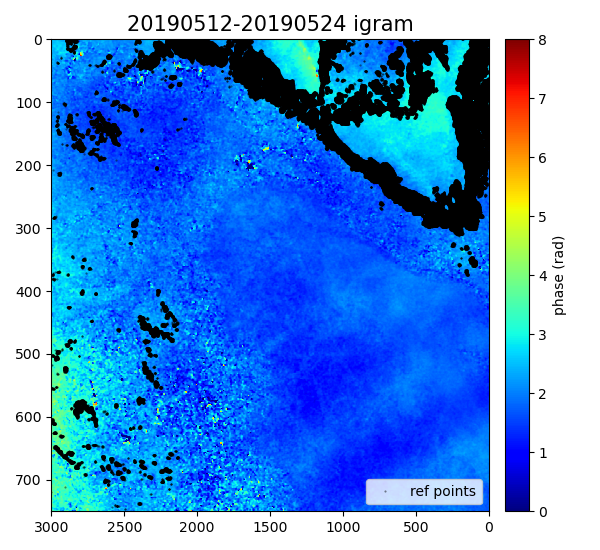

In [5]:
#k = 15 # which igram to plot? 
k = 59
date1 = dates[k]; date2 = dates[k+1]
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=0,vmax=8)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0]) #plt.xticks([]); plt.yticks([])
plt.title(str(date1)+'-'+str(date2)+' igram',fontsize=15)
if key2 == 'ref_box':
    plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='yellow',facecolor='none',linewidth=2,label='ref box'))
    plt.legend()
if key2 == 'ref_pix':
    plt.plot(mask_x,mask_y,'k.',ms=1,alpha=0.5,label='ref points')
    plt.legend()
plt.show()

Reference all the unwr_full_res igrams. Options according to key2:
1. average value (subtract avg value of each igram from each pixel in that igram)
2. box of pixels
3. pixels chosen based on criteria outlined in 'choosing_reference_pixels.ipynb'

In [6]:
# correct all igrams so there's a zero/stationary point 
# initialize an array for corrected igrams
unwr_full_res_cor = np.ndarray(np.shape(unwr_full_res),dtype='float')
if key2 == 'avg_val':
    for i in range(numIgrams):
        # remove the average phase from igram
        # (choosing that we assume no deformation across entire image, reference to the average value)
        unwr_full_res_cor[i] = unwr_full_res[i]-np.mean(unwr_full_res[i])
    print('igrams corrected by subtracting avg value.')
if key2 == 'ref_box':
    for i in range(numIgrams):
        # remove the average phase from small reference region at foot of mountains   
        unwr_full_res_cor[i] = unwr_full_res[i]-np.mean(unwr_full_res[i,150:180,800:900])
    print('igrams corrected by subtracting avg value over small reference region in mountains.')
if key2 == 'ref_pix':
    for i in range(numIgrams):
        unwr_full_res_cor[i] = unwr_full_res[i]-np.mean(unwr_full_res[i,mask_y,mask_x])
    print('igrams corrected by subtracting avg value of reference pixels chosen with 4 criteria.')

igrams corrected by subtracting avg value of reference pixels chosen with 4 criteria.


In [7]:
# if need to save RAM space, delete the original igrams here.
del unwr_full_res

Define a function for converting datetime objects to decimal years. 

In [8]:
# Need this function to convert datetime objects to decimal years. Got this off of stackexchange. 
def datetime2year(dt): 
    year_part = dt - datetime(year=dt.year, month=1, day=1)
    year_length = (
        datetime(year=dt.year + 1, month=1, day=1)
        - datetime(year=dt.year, month=1, day=1)
    )
    return dt.year + year_part / year_length

Pull out dates in order to calculate disp rates over time.

In [9]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# convert to floats 
slc_dates_floats = np.ndarray((len(slc_dates),1),dtype='float')
for i in range(len(slc_dates)):
    slc_dates_floats[i] = datetime2year(slc_dates[i]) # now an array of floats in years
# take numIgrams and pull out the igram_dates, corresponding to the second/last day of each igram
igram_dates = slc_dates[1::] # using the second SLC date per Rowena's suggestion
dt1 = np.diff(slc_dates) # calculate dt between slcs, these are now timedelta objects
# convert to floats 
dt_all = np.zeros([len(dt1),1])
for i in range(len(dt_all)):
    dt_all[i] = dt1[i].days #/365.25 # dt is now an array of floats (years btw slc acquisitions)
print('slc_dates: '+str(np.shape(slc_dates)))
print('igram_dates: '+str(np.shape(igram_dates)))
print('^datetime objects now')
#print(dt)

slc_dates: (211,)
igram_dates: (210,)
^datetime objects now


Find which dates I need to separate the time series into to fit slopes for each pixel.

In [10]:
print('first time period: '+str(dates[0])+'-'+str(dates[46]))
print('second time period: '+str(dates[47])+'-'+str(dates[107]))
print('third time period: '+str(dates[108])+'-'+str(dates[146]))
print('fourth time period: '+str(dates[147])+'-'+str(dates[-1]))
print('\ntime period overlapping with Jiang and Lohman (fifth): '+str(dates[0])+'-'+str(dates[88]))
print('entire time period (sixth): '+str(dates[0])+'-'+str(dates[numIgrams]))
#print(str(dates[numIgrams]))

print('total duration of this study: '+str((igram_dates[-1]-igram_dates[0]).days/365.25)+' years')

start_indices = [0,47,108,147,0,0]
end_indices = [46,107,146,numIgrams,88,numIgrams]
num_intervals = len(start_indices)

first time period: 20170510-20181125
second time period: 20181207-20200412
third time period: 20200418-20201208
fourth time period: 20201214-20220108

time period overlapping with Jiang and Lohman (fifth): 20170510-20191220
entire time period (sixth): 20170510-20220108
total duration of this study: 4.632443531827516 years


Load coherence files for using in weight matrices.

In [11]:
# read in coherence files
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
coh = np.ndarray((np.shape(unwr_full_res_cor)),dtype='float')
for i in range(numIgrams): #range(numIgrams)
    date1=dates[i]
    date2=dates[i+1]
    file_name = 'coh_'+str(date1)+'_'+str(date2)+'.r4'
    f1 = gdal.Open(saveDir+file_name, gdal.GA_ReadOnly)
    coh[i] = f1.ReadAsArray()
f1 = None
print('Coh maps loaded.')

Coh maps loaded.


Plot a coherence map for a day to visually check I calculated coherence correctly. (I used the coherence calculations from other notebooks so I think it's right but I want to be sure) 

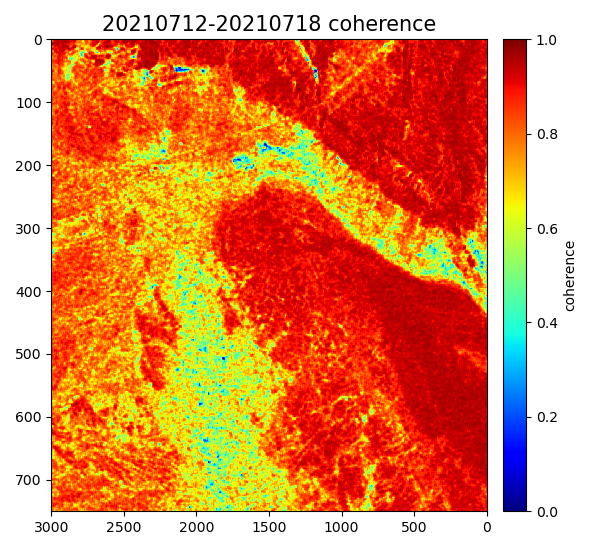

In [12]:
k = 181 # which coherence/igram to plot? 
date1 = dates[k]; date2 = dates[k+1]
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(coh[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=0,vmax=1.0)
plt.colorbar(orientation='vertical',pad=0.03,label='coherence'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0]); #plt.xticks([]); plt.yticks([])
plt.title(str(date1)+'-'+str(date2)+' coherence',fontsize=15)
plt.show()
#plt.savefig("sample_coh_map.png", transparent=True)

Invert for avg/long-term (linear) disp rates for each pixel for each time interval WEIGHTED by coherence value (calculated with the typical formula, see above). Invert using Gm=d with G accounting for double-counting dates, and weighting based on coherence (but convert coherence to standard deviation/variance first) <br>

Testing new method: just one interval, and plot out the weighted fit for one pixel and make sure it looks right. 

numDates: 	63
coh_at_pixel: 	(63,)
disps: 		(63,)


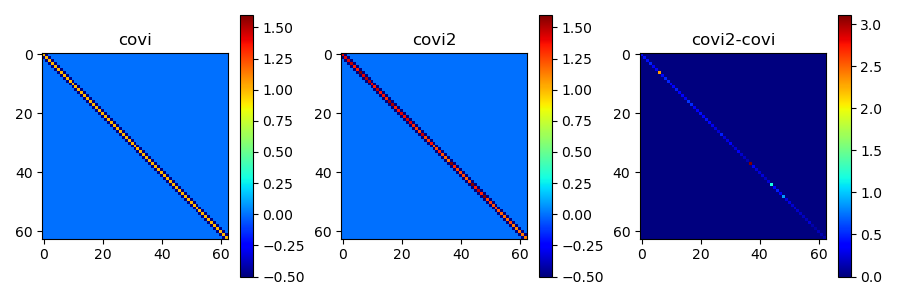

dt: 		(63,)
weighted V from disp rates: 	-3.7632816552000685


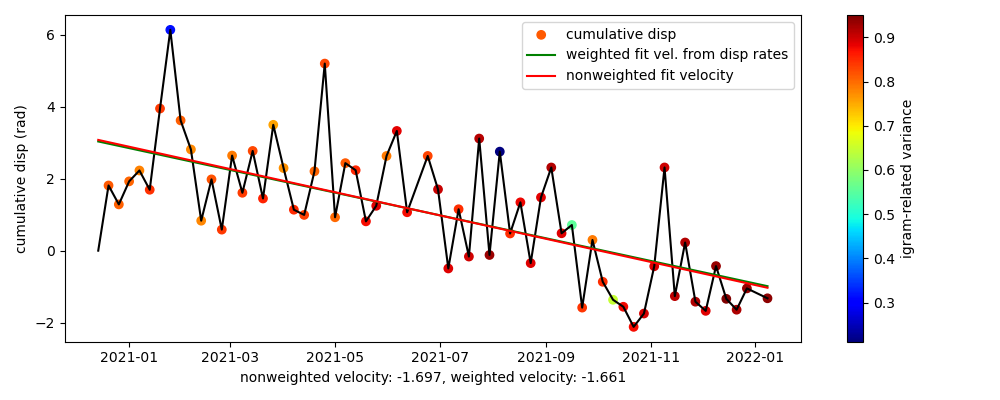

nonweighted velocity: 		-3.8439580069872377 rad/yr 	-1.6966558630212667 cm/yr
weighted vel from disp rates: 	-3.7632816552000685 rad/yr 	-1.661046731751347 cm/yr


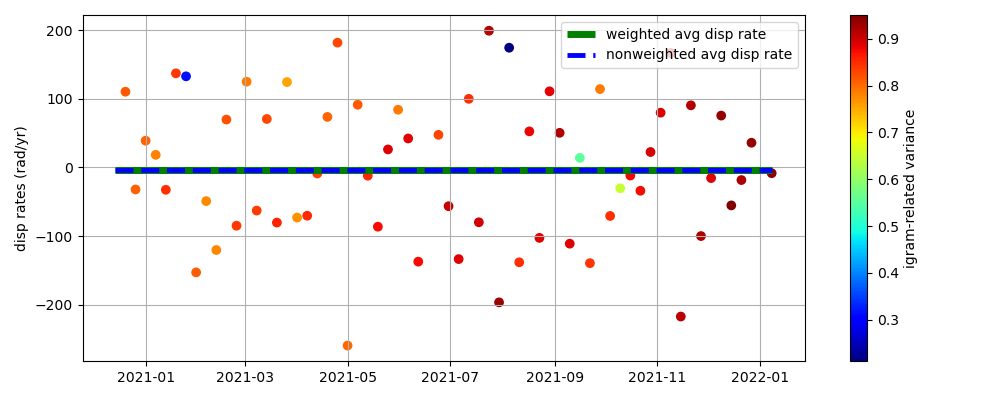

std of disp rate residuals: 	1.6706447747334037 rad/yr 	0.7373933968386048 cm/yr
mean of disp rate residuals: 	3.758367510017 rad/yr 	1.6588777139781468 cm/yr


In [18]:
j=3 # just look at the first interval for now 
#print('start index: \t'+str(start_indices[j]))  # first igram index
#print('end index: \t'+str(end_indices[j]))      # last igram index
numDates = end_indices[j]-start_indices[j] # this is number of igrams 
print('numDates: \t'+str(numDates))
    
y = dy-5 # choose a y-coordinate to plot a time series 
x = 0 # choose an x-coordinate 

# times of SLCs included in interval 
t = slc_dates_floats[start_indices[j]:end_indices[j]+1]    # first index is starting SLC, end index+1 is end SLC 
t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]  # so igram dates are t[1::], this line is for better plotting 
#print('t: \t\t'+str(np.shape(t)))

# this is date-related/atmospheric noise (instead of coherence/std.dev.s/variances which are speckle/igram-related)
noise_diags = np.ones(numDates)*1.0           # ones on diagonal 
noise_off_diags = np.ones(numDates-1)*(-0.5)    # -0.5 on off diagonals

# interferogram covariance matrix       
covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1)+np.diag(noise_off_diags,1) 
#print('covi: \t\t'+str(np.shape(covi)))

# Pull out coherence at the pixel over the interval, calculate variance and std.dev.
coh_at_pixel = coh[start_indices[j]:end_indices[j],y,x]
#coh_at_pixel[90] = 0.0001
#coh_at_pixel = np.ones(numDates,)
print('coh_at_pixel: \t'+str(np.shape(coh_at_pixel)))
variances = (-2*np.log(coh_at_pixel))   # got this formula from Rowena's cor_sigma_test.m file 
sigs = np.sqrt(variances)               # variance same as sigma (std.dev.) squared 

# OPTIONAL: make the Nth variance a HUGE number to test 
#variances[90] = 100.0

# diagonalize the variances/sigmas
sigs_diag = np.diag(sigs,0)
vars_diag = np.diag(variances,0)
#print('sigs_diag: \t'+str(np.shape(sigs_diag)))

# Combine date-related and igram-related noise into proper covariance matrix 
covi2 = covi + vars_diag # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
#print('covi2: \t\t'+str(np.shape(covi2)))

icov = np.linalg.inv(covi2)                     # inverse of covariance matrix
#print('icov: \t\t\t'+str(np.shape(icov)))

# Make d(data) matrix (change in displacement over each igram, referenced to avg value over entire igram)
disps = unwr_full_res_cor[start_indices[j]:end_indices[j],y,x]   # this is disp rates 
print('disps: \t\t'+str(np.shape(disps)))
#print(disps)

# OPTIONAL: make the Nth disp a HUGE number to test 
#disps[90] = 10.0

# Calculate cumulative displacement to do simple polyfit for comparison with weighted fit.
cum_disps = np.hstack((0,np.cumsum(disps)))
# print('cum_disps: \t'+str(np.shape(cum_disps))) # tested that diff(cum_disps)==disps 
# print(cum_disps)

# make G matrix with 1's and -1's 
G_diags = np.ones((numDates-1))
Gint = np.diag(G_diags,1)-1*np.eye(numDates)    # -1's along diagonal, 1's on upper off diagonal
#Gint = Gint[0:-1,:]                            # take off the last row, no don't do this actually 
#print('Gint: \t\t'+str(np.shape(Gint)))

# plot covariance matrices 
plt.figure(figsize=(9,3),tight_layout='TRUE')    
plt.subplot(1,3,1)  
plt.imshow(covi,interpolation='nearest',vmin=-0.5,vmax=1.6)
plt.title('covi'); plt.colorbar()
plt.subplot(1,3,2)  
plt.imshow(covi2,interpolation='nearest',vmin=-0.5,vmax=1.6)
plt.title('covi2'); plt.colorbar()
plt.subplot(1,3,3)  
plt.imshow(covi2-covi,interpolation='nearest')
plt.title('covi2-covi'); plt.colorbar()
plt.show()                           

# Calculate dt's (time intervals of each igram)
dt = np.diff(t.T)[0]                     # the indices are weird from diff, the [0] index is actually the array we want.
print('dt: \t\t'+str(np.shape(dt)))     # dt calculated earlier and dt2 calculated with np.diff are the same, good! 

# USING DISP RATE (disp per igram) AND DT
#print('disps: \t\t'+str(np.shape(disps)))
G_disps = dt.reshape((numDates,1))
#print('G_disps: \t\t'+str(np.shape(G_disps)))
Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
#print('Gg_disps_weighted: '+str(np.shape(Gg_disps_weighted)))
model_disps = Gg_disps_weighted.dot(disps)                    # weighted inversion directly from ints 
vel_disps = model_disps[0]
print('weighted V from disp rates: \t'+str(vel_disps))

# MODEL COVARIANCE NOT USEFUL because we had to estimate date/atm-related noise, so this just propagates that estimate.
# Calculate the model covariance matrix
#Cm = Gg_disps_weighted.dot(covi2).dot(Gg_disps_weighted.T)
#print('Cm: '+str(np.shape(Cm)))
#print('Model covariance: '+str(Cm))

# calculate a line from the weighted inversion for velocity, set intercept to zero.
line = vel_disps*(t-t[0]) + 0.0

# make a conversion factor from radians to cm. 
wavelength = 5.5465763          # C-band, in cm 
rad2cm = wavelength/(4*np.pi)   # this is conversion factor that I multiply by the data (which is in rads)

# a normal linear regression (to make sure weighted version is different)
m, b = np.polyfit(t.reshape((numDates+1,)),cum_disps,1)
line_nonweighted = m*t+b

plt.figure(figsize=(10,4),tight_layout='TRUE')
plt.plot(t_datetime,cum_disps,'k-')
#plt.scatter(t_datetime,cum_disps,c=coh_at_pixel,vmin=0.5,vmax=1)
plt.scatter(t_datetime[1::],cum_disps[1::],c=coh_at_pixel,label='cumulative disp')

offset = np.mean(line)-np.mean(line_nonweighted)

plt.plot(t_datetime,line-offset,'g-',label='weighted fit vel. from disp rates')
plt.plot(t_datetime,line_nonweighted,'r-',label='nonweighted fit velocity')
#plt.scatter(t_datetime[90+1],cum_disps[90+1],c=coh_at_pixel[90+1])
plt.ylabel('cumulative disp (rad)')
plt.legend(); plt.colorbar(label='igram-related variance')
plt.xlabel('nonweighted velocity: '+str(np.round(rad2cm*m,3))+', weighted velocity: '+str(np.round(rad2cm*vel_disps,3)))
#plt.xlim([min(t),max(t)])
plt.show()
print('nonweighted velocity: \t\t'+str(m)+' rad/yr \t'+str(rad2cm*m)+' cm/yr')
#print('weighted velocity: \t\t'+str(vel_cum_disp)+' rad/yr \t'+str(rad2cm*vel_cum_disp)+' cm/yr')
print('weighted vel from disp rates: \t'+str(vel_disps)+' rad/yr \t'+str(rad2cm*vel_disps)+' cm/yr')

plt.figure(figsize=(10,4),tight_layout='TRUE')
plt.grid()
plt.scatter(t_datetime[1::],disps/dt,c=coh_at_pixel)
plt.hlines(vel_disps,t_datetime[0],t_datetime[-1],color='g',linewidth=5,label='weighted avg disp rate')
plt.hlines(m,t_datetime[0],t_datetime[-1],color='b',linewidth=3.5,linestyle='--',label='nonweighted avg disp rate')
plt.ylabel('disp rates (rad/yr)')
plt.legend(loc='upper right'); plt.colorbar(label='igram-related variance')
#plt.ylim([-10,10])
plt.show()

residuals = np.abs(disps-vel_disps)
res_std = np.std(residuals)
res_mean = np.mean(residuals)
print('std of disp rate residuals: \t'+str(res_std)+' rad/yr \t'+str(rad2cm*res_std)+' cm/yr')
print('mean of disp rate residuals: \t'+str(res_mean)+' rad/yr \t'+str(rad2cm*res_mean)+' cm/yr')

In [ ]:
%%script echo skipping
# pick out points > threshhold coherence, just plot them and fit line 
threshold = 0.9
inds = np.where(coh_at_pixel>threshold)[0]
#print(inds)
#print(type(inds[0]))
coh_trimmed = coh_at_pixel[inds]
#print(np.shape(coh_at_pixel))
inds2 = inds+1
t_trimmed = t[inds].flatten()
#print(np.shape(t_trimmed))
cum_disps_trimmed = cum_disps[inds]
m2, b2 = np.polyfit(t_trimmed,cum_disps_trimmed,1)
line_trimmed = m2*t_trimmed+b2

plt.figure(figsize=(8,4),tight_layout='TRUE')
plt.plot(t,cum_disps,'k-',label='cum disp')
#plt.scatter(t_datetime,cum_disps,c=coh_at_pixel,vmin=0.5,vmax=1)
plt.scatter(t_trimmed,cum_disps_trimmed,c=coh_trimmed)
plt.plot(t_trimmed,line_trimmed,'b-',label='polyfit with threshold coh value')
plt.plot(t,line_nonweighted,'g-',label='nonweighted fit velocity')
plt.ylabel('cumulative disp (rad)')
plt.legend(); plt.colorbar(label='igram-related variance')
#plt.xlim([min(t),max(t)])
plt.show()
print('nonweighted velocity: \t\t\t'+str(m)+' rad/yr \t'+str(rad2cm*m)+' cm/yr')
print('nonweighted velocity w/ coh threshhold: '+str(m2)+' rad/yr \t'+str(rad2cm*m2)+' cm/yr')
print('weighted vel from disp rates: \t\t'+str(vel_disps)+' rad/yr \t'+str(rad2cm*vel_disps)+' cm/yr')

Loop through a bunch of atm-related noise values (diags + off diags) and see how the weighted velocity changes

In [ ]:
j=0 # just look at the first interval for now 
#print('start index: \t'+str(start_indices[j]))  # first igram index
#print('end index: \t'+str(end_indices[j]))      # last igram index
numDates = end_indices[j]-start_indices[j] # this is number of igrams 
print('numDates: \t'+str(numDates))
    
y = 1 # choose a y-coordinate to plot a time series 
x = 1 # choose an x-coordinate 

# times of SLCs included in interval 
t = slc_dates_floats[start_indices[j]:end_indices[j]+1]    # first index is starting SLC, end index+1 is end SLC 
t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]  # so igram dates are t[1::], this line is for better plotting 
#print('t: \t\t'+str(np.shape(t)))

diags_to_loop = np.arange(0.1,15.0,0.1)
velocity_vals = np.zeros(np.shape(diags_to_loop))
Cms = np.zeros(np.shape(diags_to_loop))

for i in range(np.shape(diags_to_loop)[0]):
    # this is date-related/atmospheric noise (instead of coherence/std.dev.s/variances which are speckle/igram-related)
    noise_diags = np.ones(numDates)*diags_to_loop[i]           # ones on diagonal 
    noise_off_diags = np.ones(numDates-1)*(-0.5)*diags_to_loop[i]    # -0.5 on off diagonals
    # interferogram covariance matrix       
    covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1)+np.diag(noise_off_diags,1) 
    #print('covi: \t\t'+str(np.shape(covi)))
    # Pull out coherence at the pixel over the interval, calculate variance and std.dev.
    coh_at_pixel = coh[start_indices[j]:end_indices[j],y,x]
    #coh_at_pixel = np.ones(numDates,)
    #print('coh_at_pixel: \t'+str(np.shape(coh_at_pixel)))
    variances = (-2*np.log(coh_at_pixel))   # got this formula from Rowena's cor_sigma_test.m file 
    sigs = np.sqrt(variances)               # variance same as sigma (std.dev.) squared 
    # OPTIONAL: make the Nth variance a HUGE number to test 
    #variances[9] = 100.0
    # diagonalize the variances/sigmas
    sigs_diag = np.diag(sigs,0)
    vars_diag = np.diag(variances,0)
    #print('sigs_diag: \t'+str(np.shape(sigs_diag)))
    # Combine date-related and igram-related noise into proper covariance matrix 
    covi2 = covi + vars_diag # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
    #print('covi2: \t\t'+str(np.shape(covi2)))
    icov = np.linalg.inv(covi2)                     # inverse of covariance matrix
    #print('icov: \t\t\t'+str(np.shape(icov)))
    # Make d(data) matrix (change in displacement over each igram, referenced to avg value over entire igram)
    disps = unwr_full_res_cor[start_indices[j]:end_indices[j],y,x]   # this is disp rates 
    #print('disps: \t\t'+str(np.shape(disps)))
    #print(disps)
    # OPTIONAL: make the Nth disp a HUGE number to test 
    #disps[9] = 100.0
    # Calculate cumulative displacement to do simple polyfit for comparison with weighted fit.
    cum_disps = np.hstack((0,np.cumsum(disps)))
    # print('cum_disps: \t'+str(np.shape(cum_disps))) # tested that diff(cum_disps)==disps 
    # print(cum_disps)
    # make G matrix with 1's and -1's 
    G_diags = np.ones((numDates-1))
    Gint = np.diag(G_diags,1)-1*np.eye(numDates)    # -1's along diagonal, 1's on upper off diagonal
    #Gint = Gint[0:-1,:]                            # take off the last row, no don't do this actually 
    #print('Gint: \t\t'+str(np.shape(Gint)))                         
    # Calculate dt's (time intervals of each igram)
    dt = np.diff(t.T)[0]                     # the indices are weird from diff, the [0] index is actually the array we want.
    #print('dt: \t\t'+str(np.shape(dt)))     # dt calculated earlier and dt2 calculated with np.diff are the same, good! 
    # USING DISP RATE (disp per igram) AND DT
    #print('disps: \t\t'+str(np.shape(disps)))
    G_disps = dt.reshape((numDates,1))
    #print('G_disps: \t\t'+str(np.shape(G_disps)))
    Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
    #print('Gg_disps_weighted: '+str(np.shape(Gg_disps_weighted)))
    model_disps = Gg_disps_weighted.dot(disps)                    # weighted inversion directly from ints 
    velocity_vals[i] = model_disps[0]
    #print('weighted V from disp rates: \t'+str(vel_disps))
    # Calculate the model covariance matrix
    Cm = Gg_disps_weighted.dot(covi2).dot(Gg_disps_weighted.T)
    Cms[i] = Cm[0]

# now plot it 
plt.figure(figsize=(6,3),tight_layout='TRUE')
plt.subplot(1,2,1)
plt.grid()
plt.plot(diags_to_loop,velocity_vals,'k.')
plt.ylabel('weighted velocity (rad/yr)')
plt.xlabel('diagonal value of covi matrix')
plt.subplot(1,2,2)
plt.plot(diags_to_loop,Cms,'k.')
plt.ylabel('Cm')
plt.xlabel('diagonal value of covi matrix')
plt.grid()
plt.suptitle('Atm/date-related noise test')
plt.show()

In [19]:
print(key1,key2)

filt ref_pix


Invert for the time series (to solve for average rate) using a coherence-guided method. Invert using Gm=d with G accounting for double-counting dates, and weighting based on coherence (but convert coherence to standard deviation/variance first)

Now do it for all pixels, for all time intervals. Takes over an hour to run. 

In [35]:
# This is for disps referenced to a box/small region in the mountains 
# loop through each pixel and do a weighted linear inversion for velocity (disp rate) over the different time intervals
# initialize matrix for disp rates 
disp_rates_weighted = np.ndarray((num_intervals,dy,dx),dtype='float') 
disp_rates_residual_std = np.ndarray((num_intervals,dy,dx),dtype='float')
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_for_intervals/'
driver=gdal.GetDriverByName('ISCE')
for j in np.arange(5,6,1): #range(num_intervals), range(1) will just do the first interval 
    # do I do anything else here? 
    numDates = end_indices[j]-start_indices[j]
    print('num dates in this interval: '+str(numDates))
    for y in range(dy):       # dy for all pixels 
        for x in range(dx):   # dx for all pixels 
            t = slc_dates_floats[start_indices[j]:end_indices[j]+1]     # first index is starting SLC, end index+1 is end SLC
            t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting
            noise_diags = np.ones(numDates)*1.0             # ones on diagonal 
            noise_off_diags = np.ones(numDates-1)*(-0.5)    # -0.5 on off diagonals
            covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1)+np.diag(noise_off_diags,1) 
            coh_at_pixel = coh[start_indices[j]:end_indices[j],y,x]
            variances = (-2*np.log(coh_at_pixel))   # got this formula from Rowena's cor_sigma_test.m file 
            sigs = np.sqrt(variances)               # variance same as sigma (std.dev.) squared 
            sigs_diag = np.diag(sigs,0)             # diagonalize the sigmas
            vars_diag = np.diag(variances,0)
            covi2 = covi + vars_diag # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
            icov = np.linalg.inv(covi2)                     # inverse of covariance matrix
            disps = unwr_full_res_cor[start_indices[j]:end_indices[j],y,x]   # this is disp over each igram 
            G_diags = np.ones((numDates-1))
            Gint = np.diag(G_diags,1)-1*np.eye(numDates)    # -1's along diagonal, 1's on upper off diagonal
            dt = np.diff(t.T)[0]                     # the indices are weird from diff, the [0] index is actually the array we want.
            G_disps = dt.reshape((numDates,1))
            Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
            model_disp_rates = Gg_disps_weighted.dot(disps)                     # weighted inversion directly from ints 
            vel_disp_rate = model_disp_rates[0]                                     # this just gives a velocity, no intercept 
            wavelength = 5.5465763          # C-band, in cm 
            rad2cm = wavelength/(4*np.pi)   # this is conversion factor that I multiply by the data (which is in rads)
            disp_rates_weighted[j,y,x] = rad2cm * vel_disp_rate
            model_disps = Gg_disps_weighted.dot(disps)                    # weighted inversion directly from ints 
            vel_disps = model_disps[0]
            # Cm not as useful because it heavily depends on the date/atm-related noise that we had to estimate to begin with.
            #Cm = Gg_disps_weighted.dot(covi2).dot(Gg_disps_weighted.T) # model covariance matrix
            # store vel_disps and Cm 
            disp_rates_weighted[j,y,x] = vel_disps
            disp_rates_residual_std[j,y,x] = np.std(disps-vel_disps)
    print('weighted disp rates and std of residuals calculated for interval '+str(j))
    # +' ('+str(dates[start_indices[j]])+'-'+str(dates[end_indices[j]])+')'   
    if key1 == 'unfilt':
        if key2 == 'avg_val':
            name_file_this = 'interval_'+str(j)+'_weighted_by_coh_ref_to_avg.r4'
            name_error_file = 'interval_'+str(j)+'_weighted_by_coh_ref_to_avg_residual_std.r4'
        if key2 == 'ref_box':
            name_file_this = 'interval_'+str(j)+'_weighted_by_coh_ref_to_box.r4'
            name_error_file = 'interval_'+str(j)+'_weighted_by_coh_ref_to_box_residual_std.r4'
        if key2 == 'ref_pix':
            name_file_this = 'interval_'+str(j)+'_weighted_by_coh_ref_to_pix.r4'
            name_error_file = 'interval_'+str(j)+'_weighted_by_coh_ref_to_pix_residual_std.r4'
    if key1 == 'filt':
        if key2 == 'avg_val':
            name_file_this = 'interval_'+str(j)+'_filt_weighted_by_coh_ref_to_avg.r4'
            name_error_file = 'interval_'+str(j)+'_filt_weighted_by_coh_ref_to_avg_residual_std.r4'
        if key2 == 'ref_box':
            name_file_this = 'interval_'+str(j)+'_filt_weighted_by_coh_ref_to_box.r4'
            name_error_file = 'interval_'+str(j)+'_filt_weighted_by_coh_ref_to_box_residual_std.r4'
        if key2 == 'ref_pix':
            name_file_this = 'interval_'+str(j)+'_filt_weighted_by_coh_ref_to_pix.r4'
            name_error_file = 'interval_'+str(j)+'_filt_weighted_by_coh_ref_to_pix_residual_std.r4'
    colds = driver.Create(saveDir+name_file_this,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(disp_rates_weighted[j])
    colds=None
    colds = driver.Create(saveDir+name_error_file,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(disp_rates_residual_std[j])
    colds=None
    print('weighted disp rates and std of residuals saved for interval '+str(j))
print('done.') 

num dates in this interval: 210


interval 4, dates: 20170510-20191220


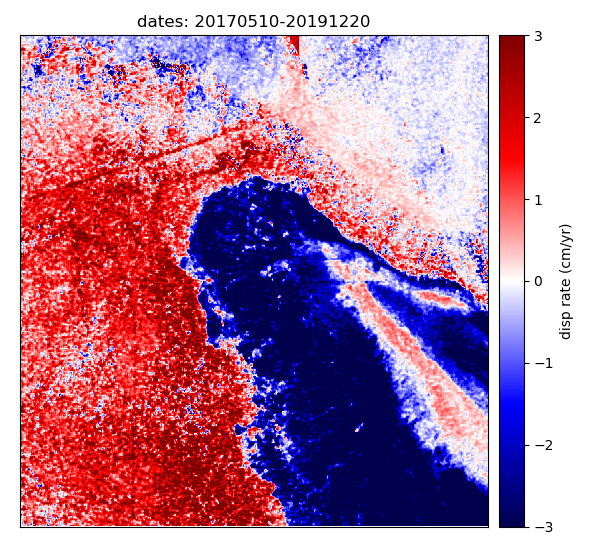

In [33]:
i = 4 # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_weighted[i], aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

interval 4, dates: 20170510-20191220


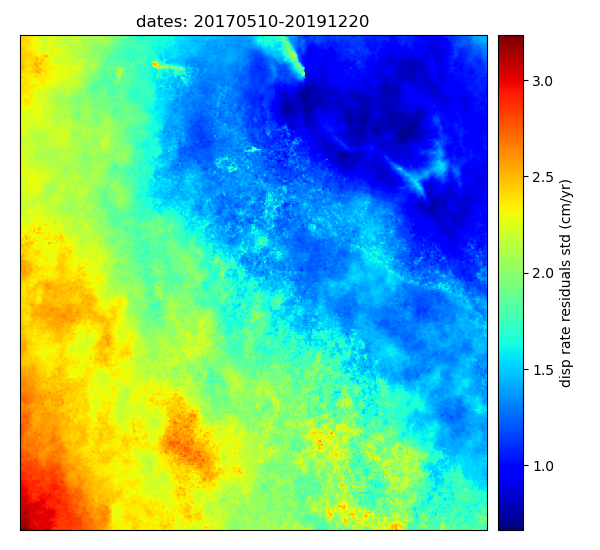

In [34]:
i = 4 # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_residual_std[i], aspect='auto', \
            interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate residuals std (cm/yr)')
plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()